In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [4]:
# Load the data
df = pd.read_csv('customer_segmentation.csv',encoding='latin1')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [9]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed', dayfirst=True)

# Calculate total spend per transaction
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

# Filter out returns (negative quantities)
df = df[df['Quantity'] > 0]

# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)

In [10]:
# Set analysis date (1 day after last purchase)
analysis_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalSpend': 'sum'  # Monetary Value
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSpend': 'MonetaryValue'
})

In [11]:
# Calculate additional features
customer_data = df.groupby('CustomerID').agg({
    'TotalSpend': ['sum', 'mean', 'std'],  # Total spend, AOV, spend variability
    'Quantity': ['sum', 'mean'],  # Total items, avg items per order
    'StockCode': 'nunique',  # Unique products purchased
    'Country': 'first',  # Customer country
    'InvoiceDate': ['min', 'max', 'nunique']  # First/last purchase, unique days
})

In [12]:
# Flatten multi-index columns
customer_data.columns = ['_'.join(col).strip() for col in customer_data.columns.values]

# Merge with RFM data
customer_data = customer_data.merge(rfm, left_index=True, right_index=True)

# Calculate customer tenure (days since first purchase)
customer_data['Tenure'] = (analysis_date - customer_data['InvoiceDate_min']).dt.days

# Calculate purchase frequency (purchases per day)
customer_data['PurchaseFreq'] = customer_data['Frequency'] / customer_data['Tenure']

# Calculate average days between purchases
customer_data['AvgDaysBetweenPurchases'] = customer_data['Tenure'] / customer_data['Frequency']

In [13]:
# Calculate customer's country (dummy variable)
customer_data['Country'] = customer_data['Country_first']
customer_data = pd.get_dummies(customer_data, columns=['Country'], drop_first=True)

# Drop unnecessary columns
customer_data.drop(columns=['InvoiceDate_min', 'InvoiceDate_max', 'Country_first'], inplace=True)

# Calculate target variable (LTV) - we'll use total spend as proxy for now
customer_data['LTV'] = customer_data['MonetaryValue']

Text(0.5, 1.0, 'Recency Distribution')

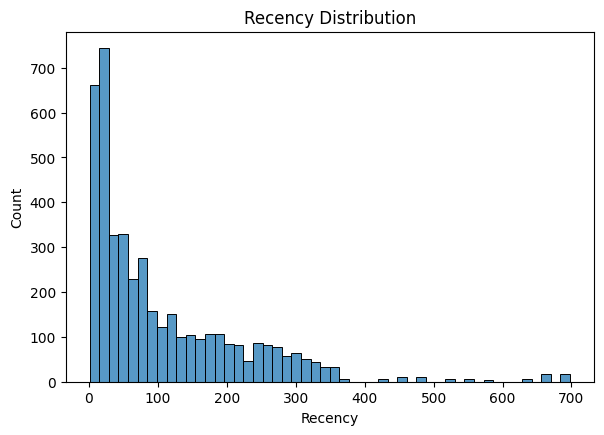

In [14]:
# Plot distributions
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(customer_data['Recency'], bins=50)
plt.title('Recency Distribution')

Text(0.5, 1.0, 'Frequency Distribution')

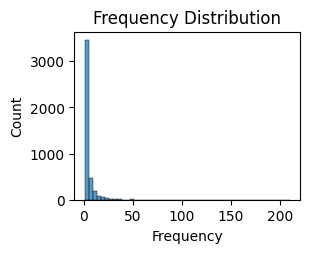

In [17]:
plt.subplot(2, 2, 2)
sns.histplot(customer_data['Frequency'], bins=50)
plt.title('Frequency Distribution')

Text(0.5, 1.0, 'Monetary Value Distribution')

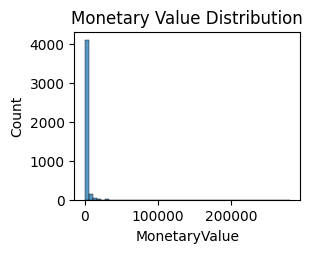

In [18]:
plt.subplot(2, 2, 3)
sns.histplot(customer_data['MonetaryValue'], bins=50)
plt.title('Monetary Value Distribution')

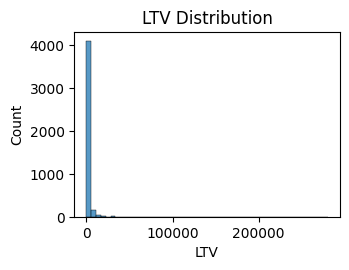

In [19]:
plt.subplot(2, 2, 4)
sns.histplot(customer_data['LTV'], bins=50)
plt.title('LTV Distribution')
plt.tight_layout()
plt.show()

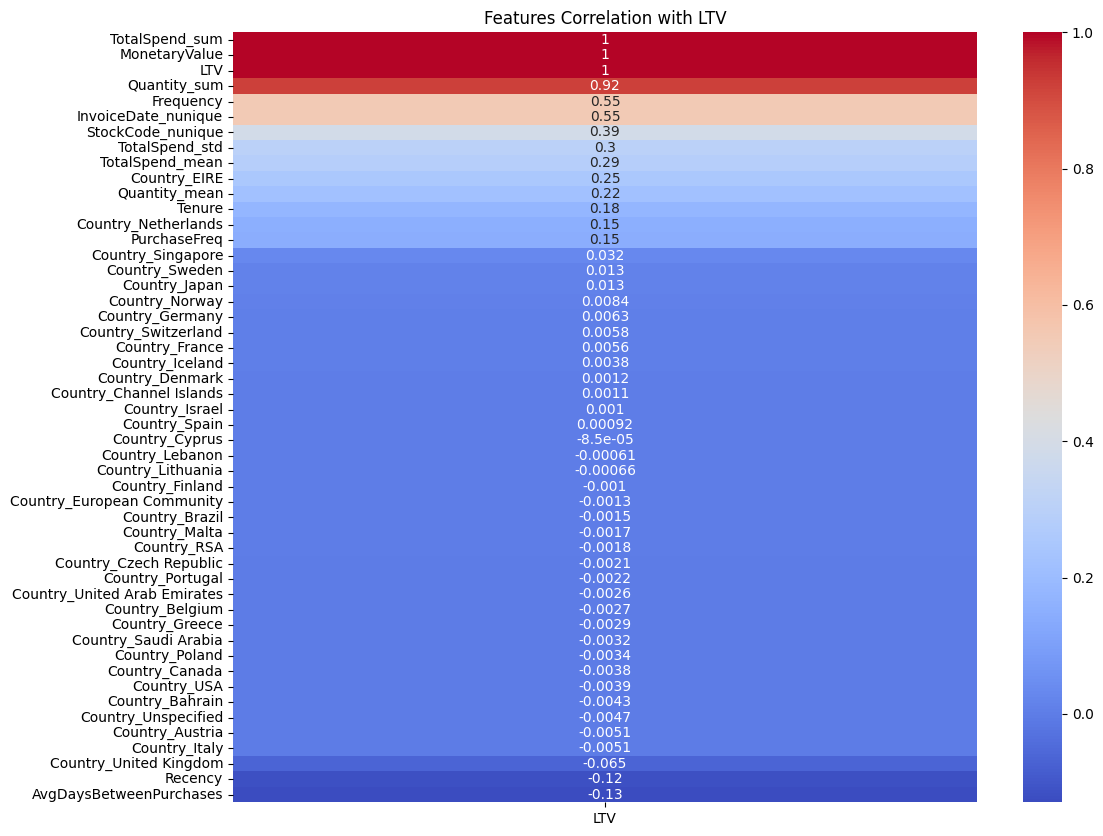

In [20]:
# Correlation matrix
corr_matrix = customer_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[['LTV']].sort_values(by='LTV', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title('Features Correlation with LTV')
plt.show()

In [21]:
# Prepare features and target
X = customer_data.drop(columns=['LTV', 'InvoiceDate_nunique'])
y = customer_data['LTV']

In [22]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [25]:
# Train XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [28]:
# Evaluate models
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    return preds

In [29]:
print("Random Forest Performance:")
rf_preds = evaluate_model(rf, X_test_scaled, y_test)

print("\nXGBoost Performance:")
xgb_preds = evaluate_model(xgb, X_test_scaled, y_test)

Random Forest Performance:
MAE: 100.96
RMSE: 2632.73

XGBoost Performance:
MAE: 146.41
RMSE: 2423.08


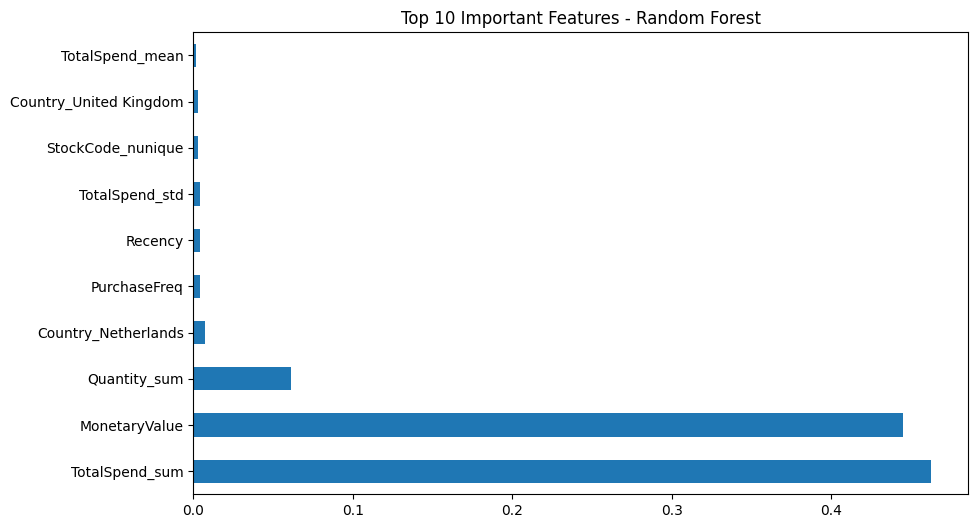

In [30]:
# Plot feature importance
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features - Random Forest')
plt.show()

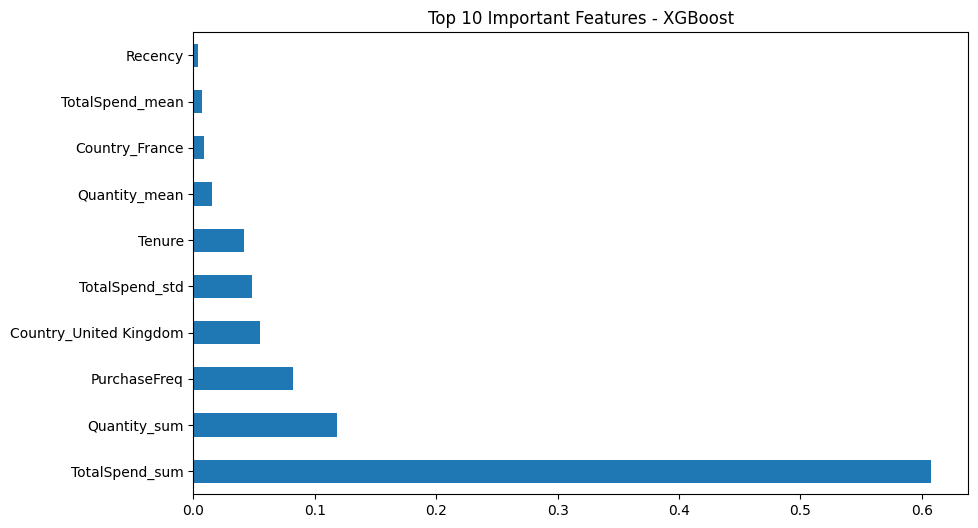

In [31]:
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(xgb.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features - XGBoost')
plt.show()

In [32]:
# Predict LTV for all customers
all_preds = xgb.predict(scaler.transform(X))

In [33]:
# Create segments
customer_data['PredictedLTV'] = all_preds
customer_data['LTVSegment'] = pd.qcut(customer_data['PredictedLTV'], 
                                    q=4, 
                                    labels=['Low', 'Medium', 'High', 'Very High'])

In [34]:
# Analyze segments
segment_analysis = customer_data.groupby('LTVSegment').agg({
    'PredictedLTV': ['mean', 'count'],
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
})
print(segment_analysis)

           PredictedLTV           Recency  Frequency MonetaryValue
                   mean count        mean       mean          mean
LTVSegment                                                        
Low          178.966904  1085  170.396313   1.265438    178.926369
Medium       464.480865  1085  132.576959   1.875576    464.369587
High        1071.563599  1084   76.988007   3.514760   1071.878137
Very High   6446.050293  1085   45.731797  10.431336   6499.092987


C:\Users\Raj Kumar\AppData\Local\Temp\ipykernel_20220\1318311957.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = customer_data.groupby('LTVSegment').agg({


In [35]:
# Save predictions
output = customer_data[['PredictedLTV', 'LTVSegment']].copy()
output.to_csv('customer_ltv_predictions.csv')

In [36]:
# Save model (optional)
import joblib
joblib.dump(xgb, 'ltv_xgboost_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

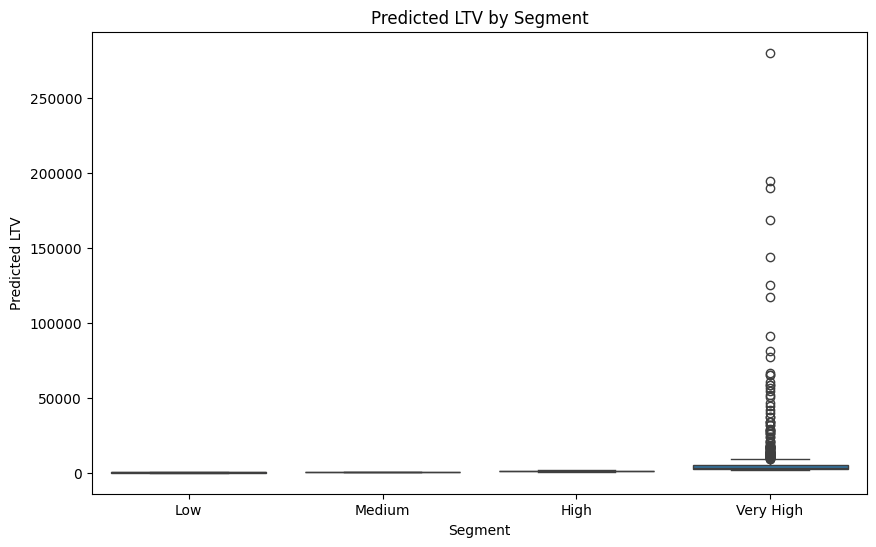

In [37]:
# LTV by segment
plt.figure(figsize=(10, 6))
sns.boxplot(x='LTVSegment', y='PredictedLTV', data=customer_data)
plt.title('Predicted LTV by Segment')
plt.ylabel('Predicted LTV')
plt.xlabel('Segment')
plt.show()

Text(0.5, 1.0, 'Recency by Segment')

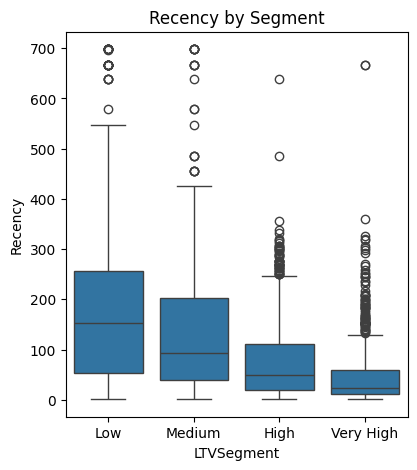

In [38]:
# RFM analysis by segment
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='LTVSegment', y='Recency', data=customer_data)
plt.title('Recency by Segment')

Text(0.5, 1.0, 'Frequency by Segment')

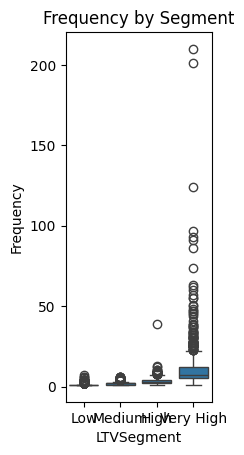

In [39]:
plt.subplot(1, 3, 2)
sns.boxplot(x='LTVSegment', y='Frequency', data=customer_data)
plt.title('Frequency by Segment')

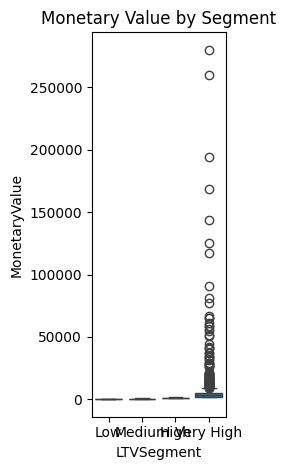

In [40]:
plt.subplot(1, 3, 3)
sns.boxplot(x='LTVSegment', y='MonetaryValue', data=customer_data)
plt.title('Monetary Value by Segment')
plt.tight_layout()
plt.show()